In [1]:
%matplotlib inline
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque, OrderedDict
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import flappy_bird_env 
import numpy as np

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# use gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\dstre\miniconda3\envs\gym\Lib\site-packages\matplotlib_inline\backend_inline.py:6: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  import matplotlib


In [2]:
# Example of taking a single step in the FlappyBird environment
env_sample = gym.make("FlappyBird-v0", render_mode="rgb_array")
observation, info = env_sample.reset(seed=0)
action = env_sample.action_space.sample()
observation, reward, terminated, truncated, info = env_sample.step(action)
env_sample.close()

print('observation shape:', observation.shape)
print('reward:', reward)
print('terminated:', terminated)
print('truncated:', truncated)
print('info:', info)

observation shape: (800, 576, 3)
reward: 0.001
terminated: False
truncated: False
info: {'background': {'upper_left': (0, 0)}, 'pipes': [{'x': 695, 'height': 390, 'top': -250, 'bottom': 590}], 'base': {'x1': -5, 'x2': 667, 'y': 700}, 'bird': {'x': 222, 'y': 377.5}, 'last_action': 0, 'score': 0}


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
NN_width = 100 # scales width of the network
num_layers = 5 # scales depth of the network
class DQN(nn.Module):
    '''
    Basic Deep Q Network to estimate the Quality function (quantitates the effectiveness of taking an action in a given state)
    '''
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.l1 = nn.Linear(n_observations, NN_width)
        layers = []
        for i in range(num_layers):
            layers.append(('hidden{}'.format(i+1),nn.Linear(NN_width, NN_width)))
            layers.append(('ReLU{}'.format(i+1), nn.LeakyReLU(0.2, inplace=True)))
        self.hidden = nn.Sequential(OrderedDict(layers))
        self.out = nn.Linear(NN_width, n_actions)
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.hidden(x)
        return self.out(x)

In [5]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


def process_state(image, downsample_factor=4):
    '''Convert images to grayscale and normalize. Then interpolate to a smaller grid to decrease compute and place into flattend torch tensor.'''
    image_gray = np.mean(image, axis=2)
    image_gray = image_gray / 255.0 #normalize
    image_gray = image_gray[::downsample_factor, ::downsample_factor] # downsample by taking every other pixel
    return torch.tensor(image_gray, dtype=torch.float32, device=device).view(1,-1)

# init env
env = gym.make("FlappyBird-v0", render_mode="rgb_array")
n_actions = env.action_space.n # will be 2 for FlappyBird
state, info = env.reset()
state = process_state(state)
n_observations = state.shape[1]

# init networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# init optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []
def plot_durations(show_result=False):
    '''
    Make a running plot of the duration of each episode as a heuristic for training progress
    '''
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [6]:
## Training Function
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the Quality function
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) - the value of all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model with backpropagation
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100) #avoid exploding gradients
    optimizer.step()

Episode 0 finished after 28 timesteps
Episode 1 finished after 27 timesteps
Episode 2 finished after 31 timesteps
Episode 3 finished after 30 timesteps
Episode 4 finished after 30 timesteps
Episode 5 finished after 26 timesteps
Episode 6 finished after 55 timesteps
Episode 7 finished after 28 timesteps
Episode 8 finished after 26 timesteps
Episode 9 finished after 29 timesteps
Episode 10 finished after 39 timesteps
Episode 11 finished after 48 timesteps
Episode 12 finished after 42 timesteps
Episode 13 finished after 27 timesteps
Episode 14 finished after 36 timesteps
Episode 15 finished after 43 timesteps
Episode 16 finished after 50 timesteps
Episode 17 finished after 24 timesteps
Episode 18 finished after 47 timesteps
Episode 19 finished after 61 timesteps
Episode 20 finished after 46 timesteps
Episode 21 finished after 26 timesteps
Episode 22 finished after 68 timesteps
Episode 23 finished after 28 timesteps
Episode 24 finished after 51 timesteps
Episode 25 finished after 34 timest

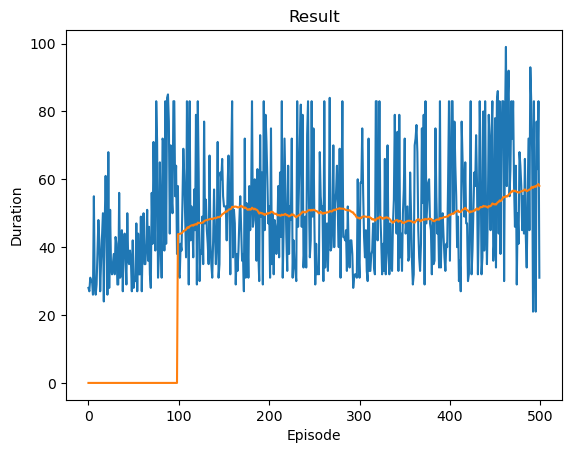

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
num_episodes = 500

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = process_state(state)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = process_state(observation)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            break
        
    print('Episode {} finished after {} timesteps'.format(i_episode, t + 1))

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [11]:
# Render the agent playing

# Create the environment
env = gym.make("FlappyBird-v0", render_mode="human")

# Set the DQN agent in evaluation mode
policy_net.eval()

# Play the game using the trained DQN agent
state, info = env.reset()
state = process_state(state)
done = False

for _ in range(1000):
    env.render()
    with torch.no_grad():
        action = select_action(state)
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
    else:
        state = process_state(observation)
env.close()
